**Ben KABONGO**, *21116436*, M1 DAC

## --- Generate text with a recurrent neural network (Pytorch) ---
### (Mostly Read & Run)

The goal is to replicate the (famous) experiment from [Karpathy's blog](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

To learn to generate text, we train a recurrent neural network to do the following task:

Given a "chunk" of text: `this is random text`

the goal of the network is to predict each character in **`his is random text` ** sequentially given the following sequential input **`this is random tex`**:




## Load text (dataset/input.txt)

Before building training batch, we load the full text in RAM

In [1]:
!wget https://thome.isir.upmc.fr/classes/RITAL/input.txt

--2023-02-17 16:01:51--  https://thome.isir.upmc.fr/classes/RITAL/input.txt
Resolving thome.isir.upmc.fr (thome.isir.upmc.fr)... 134.157.18.247
Connecting to thome.isir.upmc.fr (thome.isir.upmc.fr)|134.157.18.247|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: 'input.txt'

input.txt            26%[====>               ] 287.76K  16.0KB/s    in 3m 2s   

2023-02-17 16:05:34 (1.58 KB/s) - Connection closed at byte 294666. Retrying.

--2023-02-17 16:05:35--  (try: 2)  https://thome.isir.upmc.fr/classes/RITAL/input.txt
Connecting to thome.isir.upmc.fr (thome.isir.upmc.fr)|134.157.18.247|:443... connected.
HTTP request sent, awaiting response... 206 Partial Content
Length: 1115394 (1.1M), 820728 (801K) remaining [text/plain]
Saving to: 'input.txt'

input.txt            46%[+++++===>           ] 511.49K  8.59KB/s    in 2m 25s  

2023-02-17 16:08:00 (1.55 KB/s) - Connection closed at byte 523761. Retrying.

--2023-02-17 16:08:02-

In [2]:
#! pip install unidecode

In [3]:
import unidecode
import string
import random
import re
import torch
import torch.nn as nn

all_characters = string.printable
n_characters = len(all_characters)

file = unidecode.unidecode(open('./input.txt').read()) #clean text => only ascii
file_len = len(file)
print('file_len =', file_len)


file_len = 1115394


## 2: Helper functions:

We have a text and we want to feed batch of chunks to a neural network:

one chunk  A,B,C,D,E
[input] A,B,C,D -> B,C,D,E [output]

Note: we will use an embedding layer instead of a one-hot encoding scheme.

for this, we have 3 functions:

- One to get a random str chunk of size `chunk_len` : `random_chunk` 
- One to turn a chunk into a tensor of size `(1,chunk_len)` coding for each characters : `char_tensor`
- One to return random input and output chunks of size `(batch_size,chunk_len)` : `random_training_set`




In [4]:
import time, math


#Get a piece of text
def random_chunk(chunk_len):
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]


# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(1,len(string)).long()
    for c in range(len(string)):
        tensor[0,c] = all_characters.index(string[c])
    return tensor


#Turn a piece of text in train/test
def random_training_set(chunk_len=200, batch_size=8):
    chunks = [random_chunk(chunk_len) for _ in range(batch_size)]
    inp = torch.cat([char_tensor(chunk[:-1]) for chunk in chunks],dim=0)
    target = torch.cat([char_tensor(chunk[1:]) for chunk in chunks],dim=0)
    
    return inp, target

print(random_training_set(10,4))  ## should return 8 chunks of 10 letters. 

(tensor([[27, 18, 14, 28, 73, 96, 36, 23, 13, 94],
        [94, 10, 27, 14, 94, 34, 24, 30, 94, 28],
        [29, 94, 15, 24, 27, 29, 17, 94, 10, 94],
        [78, 94, 17, 14, 21, 25, 94, 17, 18, 22]]), tensor([[18, 14, 28, 73, 96, 36, 23, 13, 94, 12],
        [10, 27, 14, 94, 34, 24, 30, 94, 28, 24],
        [94, 15, 24, 27, 29, 17, 94, 10, 94, 31],
        [94, 17, 14, 21, 25, 94, 17, 18, 22, 73]]))


## The actual RNN model (only thing to complete):

It should be composed of three distinct modules:

- an [embedding layer](https://pytorch.org/docs/stable/nn.html#embedding) (n_characters, hidden_size)

```
nn.Embedding(len_dic,size_vec)
```
- a [recurrent](https://pytorch.org/docs/stable/nn.html#recurrent-layers) layer (hidden_size, hidden_size)
```
nn.RNN(in_size,out_size) or nn.GRU() or nn.LSTM() => rnn_cell parameter
```
- a [prediction](https://pytorch.org/docs/stable/nn.html#linear) layer (hidden_size, output_size)

```
nn.Linear(in_size,out_size)
```
=> Complete the `init` function code

In [5]:
import torch.nn.functional as f

class RNN(nn.Module):
    
    def __init__(self, n_char, hidden_size, output_size, n_layers=1,rnn_cell=nn.RNN):
        """
        Create the network
        """
        super(RNN, self).__init__()
        
        self.n_char = n_char
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        #  (batch,chunk_len) -> (batch, chunk_len, hidden_size)  
        self.embed = nn.Embedding(n_char, hidden_size)
        
        # (batch, chunk_len, hidden_size)  -> (batch, chunk_len, hidden_size)  
        self.rnn = nn.RNN(hidden_size, hidden_size)
        
        #(batch, chunk_len, hidden_size) -> (batch, chunk_len, output_size)  
        self.predict = nn.Linear(hidden_size, output_size)
    
    def forward(self, input):
        """
        batched forward: input is (batch > 1,chunk_len)
        """
        input = self.embed(input)
        output,_  = self.rnn(input)
        output = self.predict(f.tanh(output))
        return output
    
    def forward_seq(self, input,hidden=None):
        """
        not batched forward: input is  (1,chunk_len)
        """
        input = self.embed(input)
        output,hidden  = self.rnn(input.unsqueeze(0),hidden)
        output = self.predict(f.tanh(output))
        return output,hidden


## Text generation function

Sample text from the model

In [6]:
def generate(model,prime_str='A', predict_len=100, temperature=0.8):
    prime_input = char_tensor(prime_str).squeeze(0)
    hidden = None
    predicted = prime_str+""
    # Use priming string to "build up" hidden state

    for p in range(len(prime_str)-1):
        _,hidden = model.forward_seq(prime_input[p].unsqueeze(0),hidden)
            
    #print(hidden.size())
    for p in range(predict_len):
        output, hidden = model.forward_seq(prime_input[-1].unsqueeze(0), hidden)
                # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        #print(output_dist)
        top_i = torch.multinomial(output_dist, 1)[0]
        #print(top_i)
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        prime_input = torch.cat([prime_input,char_tensor(predicted_char).squeeze(0)])

    return predicted



## Training loop for net

In [7]:
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

###Parameters
n_epochs = 20000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 5
lr = 0.005
batch_size = 16
chunk_len = 80

####

model = RNN(n_characters, hidden_size, n_characters, n_layers) #create model
model_optimizer = torch.optim.Adam(model.parameters(), lr=lr) #create Adam optimizer
criterion = nn.CrossEntropyLoss() #chose criterion

start = time.time()
all_losses = []
loss_avg = 0


def train(inp, target):
    """
    Train sequence for one chunk:
    """
    #reset gradients
    model_optimizer.zero_grad() 
    
    # predict output
    output = model(inp)
    
    #compute loss
    loss =  criterion(output.view(batch_size*chunk_len,-1), target.view(-1)) 

    #compute gradients and backpropagate
    loss.backward() 
    model_optimizer.step() 

    return loss.data.item() 



for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set(chunk_len,batch_size))  #train on one chunk 
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(generate(model,'Wh', 100), '\n')
       


    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0


/Users/benkabongo25/opt/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 2s (100 0%) 2.5061]
Whinr be beame s nowhe I:
AROUSuthises m be Mbe ghat ofath be che csars osor ve s d usa s thie y an, w 

 4s (200 1%) 2.4752]
Wh, winou KE
Whis, G him.
TI have y pess llourento rs fid ws t y benours ino thof g bicengathestowis t 

 6s (300 1%) 2.5121]
Whonseeate, ste hto o fomy.

AUKIND:
ICE:
CAWe metingule.
Buse yesis ck an at, to a I tey an, ce fon t 

 9s (400 2%) 2.5132]
Wh tor ton thiothe war mangod thar by I my.

Ththe n hithe the, theramed wie pllof vewhorngr eint.


W 

 11s (500 2%) 2.4981]
Whis ane s the th profee bl ceathe an wishingnelle bet
LEDYour e OLIt thean looulangell h ing I istou  

 13s (600 3%) 2.5014]
Whase fts.
Anarerethalin prifes plleakng andur the hinck?

He lt hers lyo l of ce bit bathiispline me  

 15s (700 3%) 2.4683]
Whinanome,
TI f thace, VI manthig f he brerod ar s,
Thamasusent orin's bestothe h a isele'd unayougred 

 18s (800 4%) 2.4381]
Whatharsutary thyour in toure, ond bes Thave, ull s rd
RCESushe t
ORGove is hilellll g kear, 

 22s (6400 32%) 2.4445]
Wh.
I arovenyorendeshe tee'dou ang hende
Bouclllu y thinde le d aiss?
SI marin her, Thind t he OPA:

A 

 24s (6500 32%) 2.4444]
Whe CENIA knfore in, whe theat n hiry ate atheenurdoyobe d m IAn brd tyo be ndu llllequthel'soforavemy 

 26s (6600 33%) 2.4470]
Why he bis ppord o t nd, pat l anke ind ars be herathe y dseang nd atat d llore an, towiu e llofan'd t 

 29s (6700 33%) 2.4265]
Whethe LO:
F my I then hithere aves fo bles.
CENCINI prmy tos, thor n ig y, ave.

Any wand, mesol goth 

 31s (6800 34%) 2.5030]
Whe bod s s my,
Hachaime thelld or y hand te ll.


A:
O:
Seno t's mico and ir here, m in inghith m ial 

 33s (6900 34%) 2.4779]
Whaire tiseal cher as halt bearit sthe gheacksherd f t ghane t t on we, r ha ache, thourese the,
Thear 

 35s (7000 35%) 2.3995]
Whe hats, hore g pely he,
LANCl t.
TENETharit

He whive mpoull st;

LELaraid ano deait the t hir o me  

 37s (7100 35%) 2.5068]
Whovis.

I Whes pre,
hs.
Be I sthe I t le he cen n.
ANavated f htes be, y

 40s (12600 63%) 2.4808]
Whes hethe if tar anag wanoul tind the ffl t drol co ll t y ave g s mar ar winongathe theer.

Gorardou 

 43s (12700 63%) 2.4793]
When?
VIOMENellllend thofowiend s, therd,

Th sestha ofour verd s m cis irele Boft onghente,

Thithert 

 45s (12800 64%) 2.5183]
Whe hire trd, t t t



PENThese whers ind ard herofil lowourothef thea f lilloures athest irrtr s,
And 

 47s (12900 64%) 2.4907]
Whouk at, ge lind o ar hithe ho S do thowofave har arer bes ay yod'lowisis I unt cathare m an m hin.
H 

 49s (13000 65%) 2.4667]
Whed t and bla the t S:


Thaman g was y the y gheee theris thid y dy:
OLopoumathome the e t avercon a 

 52s (13100 65%) 2.4299]
Whis the athe t; se t bur shinthes ille IO:
HAnt;
Th had ans, ith g a yof arosese wis ack lando this a 

 54s (13200 66%) 2.4917]
Wheerd n h is sh ing acatr thilescawe iour?
Ausenef ang y y sen wily.

INRENAn LI nonoungampsthy brdos 

 56s (13300 66%) 2.5117]
Whessteau ome thans,
Tout wigre IO gowam thil s o f; moueang s th

 5s (18800 94%) 2.3899]
Whe be le irde s thend lore f meawot ou pinelingrashe s here inen therstiserend, s ft the dou a burser 

 7s (18900 94%) 2.4935]
Whe athithim. me.
Fine m te mald bre thor fomave he han Wend gm thice t t hinotisam thy
SI at fatheayo 

 9s (19000 95%) 2.4099]
Whimealist nes tom hit woufrmese he y felor?
'le bed lld

HI mounerstong is withas manghitivirarisheng 

 11s (19100 95%) 2.4342]
Whoudour it hourer othar se fonounofe lowitonoofeed f he thonter omorefe he therilal wact basth t.
Ano 

 14s (19200 96%) 2.4103]
Whit smethe fo s the coout the thars itharepepthearus o l ie st sund ghee?
TIOUSporoun
hint le:
Pik s  

 16s (19300 96%) 2.3942]
Whosthon t,
GULandour e bopay gr fowan.
Has oo tey IRI the we te 'den ath he allyo ofathithene s fofow 

 18s (19400 97%) 2.4763]
Whe DWhe the te tos, s. th t!
Tond melelllou ondey, mey r sthathe a e m;
Wher mesor:
Conduthiou, y s s 

 21s (19500 97%) 2.5134]
Wh artheswe s d. thend, flfowil y bl mstede winther at t ghe te winb

## Visualize loss 

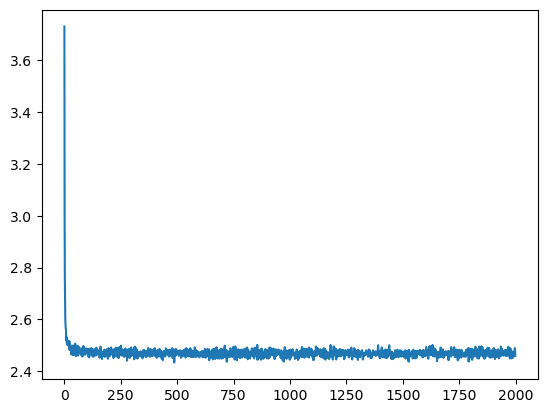

In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

## Try different temperatures

Changing the distribution sharpness has an impact on character sampling:

more or less probable things are sampled

In [9]:
print(generate(model,'T', 200, temperature=1))
print("----")
print(generate(model,'Th', 200, temperature=0.8))
print("----")

print(generate(model,'Th', 200, temperature=0.5))
print("----")

print(generate(model,'Th', 200, temperature=0.3))
print("----")

print(generate(model,'Th', 200, temperature=0.1))

The ine thotor hitsth


Ty ma swe

Serentooofiter f-k:
Co horethe te KE:
FO:
BEEve maros I thit ous.

We LEOSI sepale ont od d fand ir prlfifousthurepf can,

Thaye rman, t ceend ts, y y kssovil ontige 
----
Thouly in, ar hathethurollo whin the ple lor henrd ther, migherif therof we
TEO, letyorathe in t f thoute an igheronds fr chothe ong s he thaco mer:
HAUCir atimyoukn swd
An m figuscemen seno ame hist nd
----
There he tho se f hathearend le me:
PEOLA:

ARENonond s ant t ll s thierd thar thand she the the me save the ndwar thath is malonthare the wite, are aland tourer s he whe and sou the the ate, y sther he
----
There anor be t the the herende the the t as the the the the t h the athe me the the t thave ther the athe my the the the t whe t he the are he t anou the s the the the the the the the in the the thar t
----
The the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the t

/Users/benkabongo25/opt/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


### Improving this code:

(a) Tinker with parameters:

- Is it really necessary to have 100 dims character embeddings
- Chunk length can be gradually increased
- Try changing RNN cell type (GRUs - LSTMs)

(b) Add GPU support to go faster


In [10]:
def main(
    ###Parameters
    n_epochs = 20000,
    print_every = 100,
    plot_every = 10,
    hidden_size = 100,
    n_layers = 5,
    lr = 0.005,
    batch_size = 16,
    chunk_len = 80,
):

    model = RNN(n_characters, hidden_size, n_characters, n_layers) #create model
    model_optimizer = torch.optim.Adam(model.parameters(), lr=lr) #create Adam optimizer
    criterion = nn.CrossEntropyLoss() #chose criterion

    start = time.time()
    all_losses = []
    loss_avg = 0


    def train(inp, target):
        """
        Train sequence for one chunk:
        """
        #reset gradients
        model_optimizer.zero_grad() 

        # predict output
        output = model(inp)

        #compute loss
        loss =  criterion(output.view(batch_size*chunk_len,-1), target.view(-1)) 

        #compute gradients and backpropagate
        loss.backward() 
        model_optimizer.step() 

        return loss.data.item() 



    for epoch in range(1, n_epochs + 1):
        loss = train(*random_training_set(chunk_len,batch_size))  #train on one chunk 
        loss_avg += loss

        if epoch % print_every == 0:
            print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
            print(generate(model,'Wh', 100), '\n')



        if epoch % plot_every == 0:
            all_losses.append(loss_avg / plot_every)
            loss_avg = 0

    
    plt.figure()
    plt.plot(all_losses)

 4s (100 0%) 2.4651]
Wheve fe y cathe oueat t esashys urde e CI dumallen, out heell homyore cour.
Tht amamsee hitheermathis 

 8s (200 1%) 2.5782]
Whe,
Anund, pe d, mind urod it ousthofod br.

Tou bthathe it s! at ooreme hevery ang man theforelit t  

 12s (300 1%) 2.4596]
Whind t s ndo sthavid ly to acare y thage, y a! t gu win w wid INThan
TNar d he
THAUCEr s, ter wand y  

 16s (400 2%) 2.5177]
Whe ma kenonty fapot s RI y:
The beshe athe m s; wave aie t fall'sende se d tou lllan atar wowagourong 

 20s (500 2%) 2.5059]
Whin, t ovinte th wootous iserind INThisthere con tor heas hanghed t anathew.
BRARLUTw cet pthe e, who 

 24s (600 3%) 2.5602]
Whastllime ce me thisilo m h VIO:
Goutst s bet yomoou t IO:
I than y, m s my lesthavist tour taker tho 

 28s (700 3%) 2.4853]
Whes w, aint s rle he u winge, m t d th his,

IOMI se d m, wal ay I woubouathellse herd y arert owinay 

 32s (800 4%) 2.4606]
Wheave anoby f thourd fs hinomatharur t ls in nciser.
Tope ker f my ounger t w aur Han thea

 31s (6400 32%) 2.4650]
Whe t wimervinend t anorsase hand wethatatrervenorare aritherirer w wnd phoresshimpereano y t s ma be  

 35s (6500 32%) 2.4867]
Whistatur by llllous hawanghand t d t ge t, t!
ARK:
Thed wer winerachenerkeres se the se y t winaraknd 

 39s (6600 33%) 2.5697]
Whe, p y bloro henopur mantirs pad cerdou th s,
Thar wal co wourouray pprdat athe sintes I apus he'd
W 

 44s (6700 33%) 2.5309]
Wherede cin g t d o be llee te l dooret bu tte our ander, are
I the by ord okenot stinon te t med lo h 

 48s (6800 34%) 2.4640]
Whe t owe hene whery ts hes t acout by ase myo ce the blle y shindero hifeil.
I thrist med, I'so INall 

 52s (6900 34%) 2.4873]
Wher d werabe outhomigeananealu gr e his y myivon n't y id ce f tre

Pee
Bury than's.
Heallerin y on I 

 56s (7000 35%) 2.5345]
Whes IEThe.



Kan, waithe berere ef me:
CHAn,

MI'shind
TI dsandas al o he onores heno f le d oure


 

 1s (7100 35%) 2.4688]
Whove y s; r'd o thit mer meers thind. hecy berines t:
ANo sles yotedld an

 6s (12600 63%) 2.5160]
Whe t?

HARINCENI otemey:

HEl ather's thed t cres the t mak.
Be:


TH:
Incothe thenge chalin arol ain 

 10s (12700 63%) 2.4876]
Whouthin ialle onghavind nd ghe tore t tre! ghave ron ienortisth.
Aned bayot touconoray nghanandarel
F 

 14s (12800 64%) 2.4987]
Whe ape asure otithenttrerd ot tirotitwerebeato l our hirtherd footren owis tis no totorourerlvap thai 

 19s (12900 64%) 2.4888]
Wherin yit y, n'sthin be o hy:
I d owicord he ou, I on he t the?
NI oufiched shis sthe
Ash I s:
Fire!  

 23s (13000 65%) 2.3981]
Whalf ane sthe thes t mend has anse wise n mespengal celorthane t!
SPENRIUSSBelll hene at, st me t nd  

 27s (13100 65%) 2.5383]
Whend the cokis fe anol, cerir p n:
LINou wind e hso hanghe cking bbee w lachokn thind t mimy, t yo th 

 31s (13200 66%) 2.5430]
Whethyove wothores y tis sthinthe s alle th r CE:
The, s grethe southeee here wis my:
LET:
Mad bus an? 

 36s (13300 66%) 2.4773]
Whad linng or iomistesthe, beigon t s r hin br SThe oure wr sed he

 32s (18800 94%) 2.5101]
Whitar Fincereay bery ghew hy fay; my n ed w and nd ce, anglvenuranemathir wher a VIS:
Al chegin, g ha 

 37s (18900 94%) 2.5543]
Whe s ad s e me
Toull has whases oe s the Sis'd tangean fo wh whoubucoum thangste aro tos ber whthee s 

 41s (19000 95%) 2.5382]
Whate n dust wat y t urt y of aphe'd
G me tod bot. bon aur t co cous ybr athange ithid atwhot thaked a 

 45s (19100 95%) 2.5605]
Wh s athe we ce thor knd th MERI ppo ndoursick
A:
Thimomar'
K: bow nd the werore, f s adargacofond nd  

 50s (19200 96%) 2.5021]
Wheling s m ithe y, ldorn imy the whagheet that st:
My g y ck bl h indinoriratow;
o sprimathed is lono 

 54s (19300 96%) 2.5174]
Wh dsye thed is ppalanck thedeandisthome genoor oor wies ounousertherrqu tht y.
S:
Whe, shak
HAusecked 

 58s (19400 97%) 2.5015]
Wher an
Winef ne,
Aneoutlathe my hen, as ORY hit tyooube.

TIO:
badoun t le bes'doule, t t at t.
Be,

 

 2s (19500 97%) 2.4830]
Wher
Thithed the is hiauritoun; hances mis ard, bend pilandakiage,

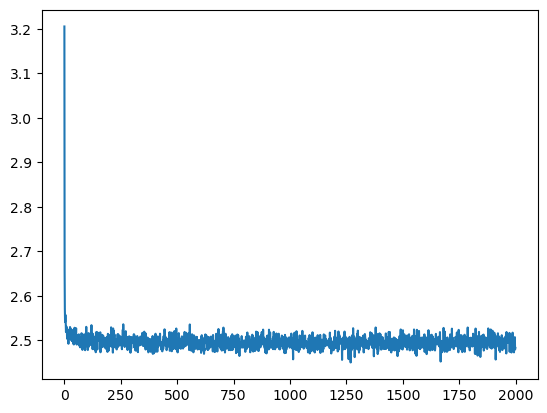

In [11]:
main(hidden_size=300)